In [1]:
# Standard library imports
import argparse
import json
import os
import sys
from datetime import date, datetime, time as dtime
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from urllib.parse import urlencode

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import requests
import seaborn as sns
from dotenv import load_dotenv
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from scipy.optimize import curve_fit

# ---------------------------------
# Config
# ---------------------------------
DATA_XLSX = '../data/multi_site_data.xlsx'
RAW_SHEET = 'RawData'
DAILY_SUMMS_SHEET = 'DailySummaries'
BIRDCAST_PARQUET = '../../birdcast-data-grabber/data/birdcast_data.parquet'
load_dotenv()

# Time-binning config
TIME_BIN_START_HOUR = 0     # 6 AM
TIME_BIN_END_HOUR = 23      # 8 PM (20 in 24h)
TIME_BIN_MINUTES = 30       # 30-minute bins

# Plot config
PLOTLY_RENDERER = 'browser'

# Weather/Sunrise config
WEATHER_API_KEY = os.getenv('WEATHER_API_KEY')
LATITUDE = 30.09
LONGITUDE = -81.61

# ---------------------------------
# Dashboard Export Functions
# ---------------------------------
# Create dashboard output directory
DASHBOARD_DIR = '../docs/dashboard_plots'
os.makedirs(DASHBOARD_DIR, exist_ok=True)
os.makedirs(f'{DASHBOARD_DIR}/images', exist_ok=True)
os.makedirs(f'{DASHBOARD_DIR}/interactive', exist_ok=True)

print(f"Dashboard plots will be saved to: {DASHBOARD_DIR}")

# Function to save matplotlib plots
def save_plot_for_dashboard(fig, filename, title, description=""):
    """Save matplotlib figure for dashboard with metadata."""
    # Save as high-res PNG
    png_path = f'{DASHBOARD_DIR}/images/{filename}.png'
    fig.savefig(png_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    # Create metadata file
    metadata = {
        'title': title,
        'description': description,
        'filename': filename,
        'type': 'matplotlib',
        'created': datetime.now().isoformat(),
        'image_path': f'images/{filename}.png'
    }
    
    with open(f'{DASHBOARD_DIR}/{filename}.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"Saved: {title} -> {filename}")
    return filename

Dashboard plots will be saved to: ../docs/dashboard_plots


In [2]:
# ---------------------------------
# Helpers for time-binning & plots
# ---------------------------------
def build_time_bins(start_hour: int = TIME_BIN_START_HOUR,
                    end_hour: int = TIME_BIN_END_HOUR,
                    step_minutes: int = TIME_BIN_MINUTES) -> Tuple[List[dtime], List[str]]:
    time_bins: List[dtime] = []
    for hour in range(start_hour, end_hour + 1):
        for minute in range(0, 60, step_minutes):
            if hour == end_hour and minute >= 60:
                break
            time_bins.append(dtime(hour, minute))
    time_labels = [t.strftime('%I:%M %p') for t in time_bins]
    return time_bins, time_labels


def assign_time_bin_factory(time_bins: List[dtime]):
    # Returns a function that maps a datetime.time -> index of its bin
    def assign_time_bin(t):
        if t is None or pd.isna(t):
            return None
        t_minutes = t.hour * 60 + t.minute
        for i, bin_time in enumerate(time_bins):
            bin_minutes = bin_time.hour * 60 + bin_time.minute
            if t_minutes < bin_minutes + TIME_BIN_MINUTES:
                return i
        return len(time_bins) - 1
    return assign_time_bin


def prepare_complete_data(raw_df: pd.DataFrame,
                          time_bins: List[dtime]) -> Tuple[pd.DataFrame, List[str], list, list, pd.DataFrame]:
    # Ensure Time column is datetime.time
    if not np.issubdtype(pd.Series(raw_df['Time']).dtype, np.dtype('O')):
        raw_df = raw_df.copy()
        raw_df['Time'] = pd.to_datetime(raw_df['Time'], format='%H:%M:%S').dt.time

    time_bins, time_labels = build_time_bins()
    assign_time_bin = assign_time_bin_factory(time_bins)

    df = raw_df.copy()
    df['TimeBin'] = df['Time'].apply(assign_time_bin)
    df = df.dropna(subset=['TimeBin'])

    grouped_data = df.groupby(['Date', 'TimeBin']).size().reset_index(name='Count')

    all_dates = sorted(df['Date'].unique())
    all_time_bins = list(range(len(time_bins)))

    complete_grid = pd.DataFrame([(date, tb) for date in all_dates for tb in all_time_bins],
                                 columns=['Date', 'TimeBin'])

    complete_data = complete_grid.merge(grouped_data, on=['Date', 'TimeBin'], how='left').fillna(0)

    dates = sorted(complete_data['Date'].unique())
    time_bin_indices = sorted(complete_data['TimeBin'].unique())
    return complete_data, time_labels, dates, time_bin_indices, grouped_data

def plot_heatmap_counts(complete_data: pd.DataFrame,
                        time_labels: List[str],
                        title: str = 'Heatmap: Date vs Time of Day vs Observation Count') -> None:
    heatmap_data = complete_data.pivot(index='TimeBin', columns='Date', values='Count')
    fig = plt.figure(figsize=(12, 10))
    sns.heatmap(
        heatmap_data,
        xticklabels=[d.strftime('%m/%d') for d in heatmap_data.columns],
        yticklabels=[time_labels[int(i)] for i in heatmap_data.index],
        cmap='viridis',
        cbar_kws={'label': 'Count of Observations'},
        annot=True,
        fmt='g',
        linewidths=0.5
    )
    # plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Date', fontsize=30, labelpad=12)
    plt.ylabel('Time of Day', fontsize=30, labelpad=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    return fig


def plot_heatmap_proportions(complete_data: pd.DataFrame,
                             time_labels: List[str],
                             title: str = 'Heatmap: Date vs Time of Day vs Proportion of Observations') -> None:
    complete_with_totals = complete_data.copy()
    complete_with_totals['Daily Total'] = complete_with_totals.groupby('Date')['Count'].transform('sum')
    complete_with_totals['Daily Proportion'] = (complete_with_totals['Count'] / complete_with_totals['Daily Total']).round(2)
    heatmap_data = complete_with_totals.pivot(index='TimeBin', columns='Date', values='Daily Proportion')

    fig = plt.figure(figsize=(12, 10))
    sns.heatmap(
        heatmap_data,
        xticklabels=[d.strftime('%m/%d') for d in heatmap_data.columns],
        yticklabels=[time_labels[int(i)] for i in heatmap_data.index],
        cmap='viridis',
        cbar_kws={'label': 'Proportion of Observations'},
        annot=True,
        fmt='g',
        linewidths=0.5
    )
    # plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Date', fontsize=30, labelpad=12)
    plt.ylabel('Time of Day', fontsize=30, labelpad=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    return fig

In [3]:
# Load data from Excel
raw_data = pd.read_excel(DATA_XLSX, sheet_name=RAW_SHEET)
raw_data = raw_data.dropna(subset=['RightPecks'])
raw_data['Date'] = pd.to_datetime(raw_data['Date'])

daily_summs = pd.read_excel(DATA_XLSX, sheet_name=DAILY_SUMMS_SHEET)
daily_summs['Date'] = pd.to_datetime(daily_summs['Date'])

# Basic plots of the action

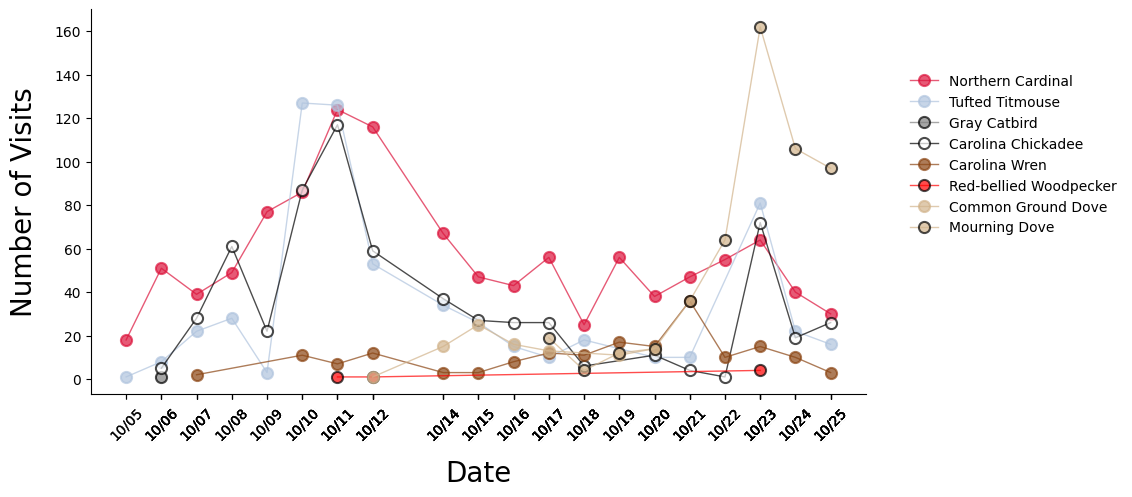

In [4]:
# Define custom colors for each bird species
bird_colors = {
    'Northern Cardinal': '#DC143C',         # Cardinal red
    'Tufted Titmouse': '#B0C4DE',           # Light blue gray
    'Gray Catbird': '#808080',              # Gray
    'Carolina Chickadee': '#FFFFFF',        # White
    'Carolina Wren': '#8B4513',             # Medium brown
    'Red-bellied Woodpecker': '#FF0000',    # Red
    'Common Ground Dove': '#D2B48C',        # Tan
    'Mourning Dove': '#D2B48C'              # Tan
}

# Define marker edge colors for birds that need black outlines
bird_edge_colors = {
    'Northern Cardinal': '#DC143C',
    'Tufted Titmouse': '#B0C4DE',
    'Gray Catbird': 'black',
    'Carolina Chickadee': 'black',
    'Carolina Wren': '#8B4513',
    'Red-bellied Woodpecker': 'black',
    'Common Ground Dove': '#D2B48C',
    'Mourning Dove': 'black'
}

fig, ax = plt.subplots(figsize=(10, 5))

# Plot each bird species individually with custom colors
for bird in daily_summs['Bird'].unique():
    bird_data = daily_summs[daily_summs['Bird'] == bird]
        # Use different colors for line and marker for Carolina Chickadee
    if bird == 'Carolina Chickadee':
        line_color = '#000000'  # Black line
        marker_color = '#FFFFFF'  # White marker
    else:
        line_color = bird_colors[bird]
        marker_color = bird_colors[bird]
    
    ax.plot(
        bird_data['Date'], 
        bird_data['Feeder Visits'], 
        marker='o', 
        markersize=8,
        markerfacecolor=marker_color,
        markeredgecolor=bird_edge_colors[bird],
        markeredgewidth=1.5,
        linewidth=1,
        color=line_color,
        label=bird, 
        alpha=0.7
    )

ax.set_ylabel('Number of Visits', fontsize=20, labelpad=12)
ax.set_xlabel('Date', fontsize=20, labelpad=12)
ticks = daily_summs['Date']
ax.set_xticks(ticks=ticks, labels=ticks.dt.strftime('%m/%d'), rotation=45)
ax.tick_params(labelsize=10)
for label in ax.get_xticklabels():
    label.set_fontweight('normal')
    label.set_fontfamily('sans-serif')
sns.despine(top=True, right=True)
plt.legend(loc=(1.05, 0.4), frameon=False)
plt.show()

In [5]:
# Save species visits plot for dashboard
save_plot_for_dashboard(
    fig, 
    'species_visits_by_date', 
    'Daily Bird Feeder Visits by Species',
    'Line plot showing daily feeder visits for each bird species with custom color coding'
)


Saved: Daily Bird Feeder Visits by Species -> species_visits_by_date


'species_visits_by_date'

## Set up data for heatmap plots

In [6]:
# Build complete data and plot 3D surface using helpers
_time_bins, _time_labels = build_time_bins()
complete_data, time_labels, dates, time_bin_indices, grouped_data = prepare_complete_data(raw_data, _time_bins)

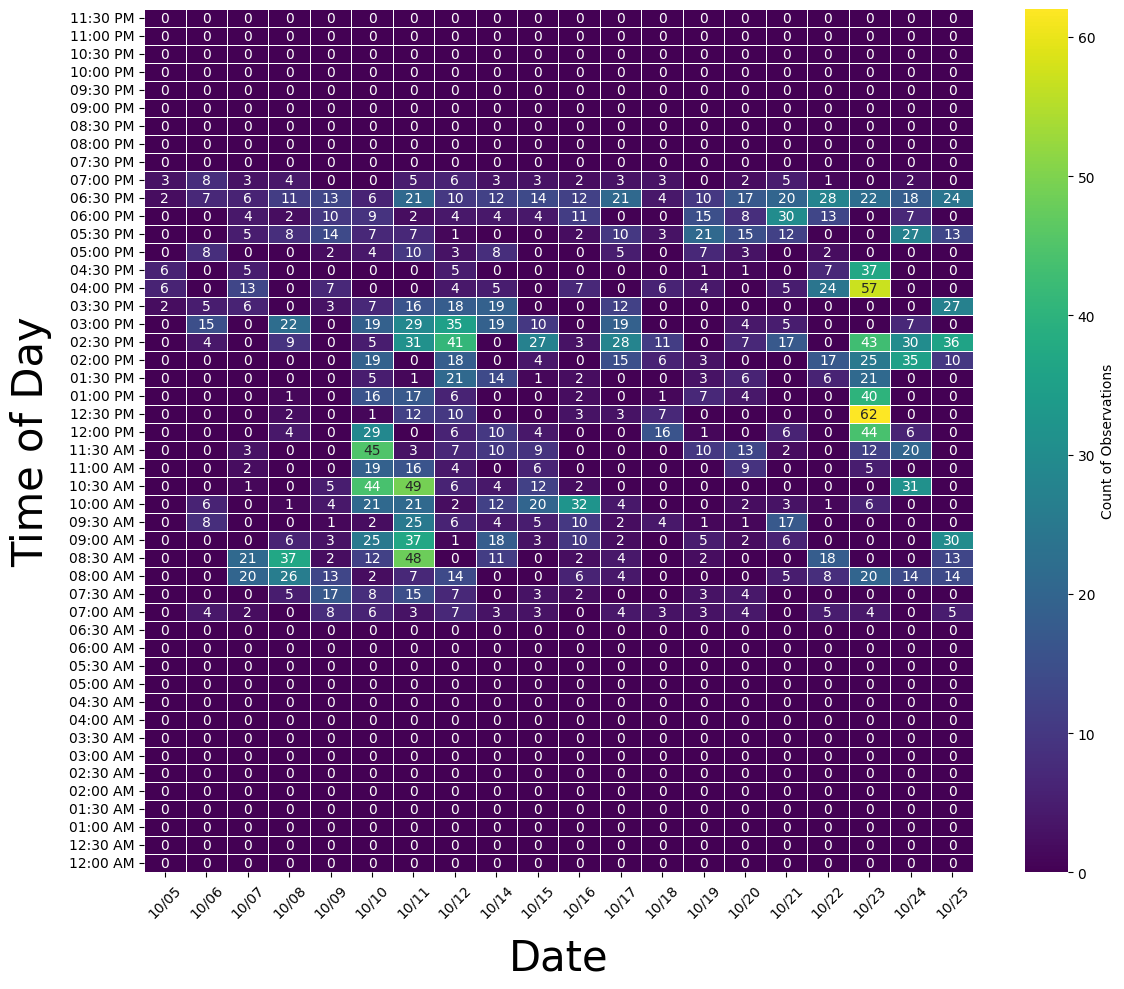

Saved: Heatmap: Date vs Time of Day vs Observation Count -> heatmap_counts


'heatmap_counts'

In [7]:
# Reuse prepared data to plot heatmap of counts
fig = plot_heatmap_counts(complete_data, time_labels)

# Save heatmap plots for dashboard
save_plot_for_dashboard(
    fig, 
    'heatmap_counts', 
    'Heatmap: Date vs Time of Day vs Observation Count',
    'Heatmap showing bird activity patterns across dates and times of day'
)

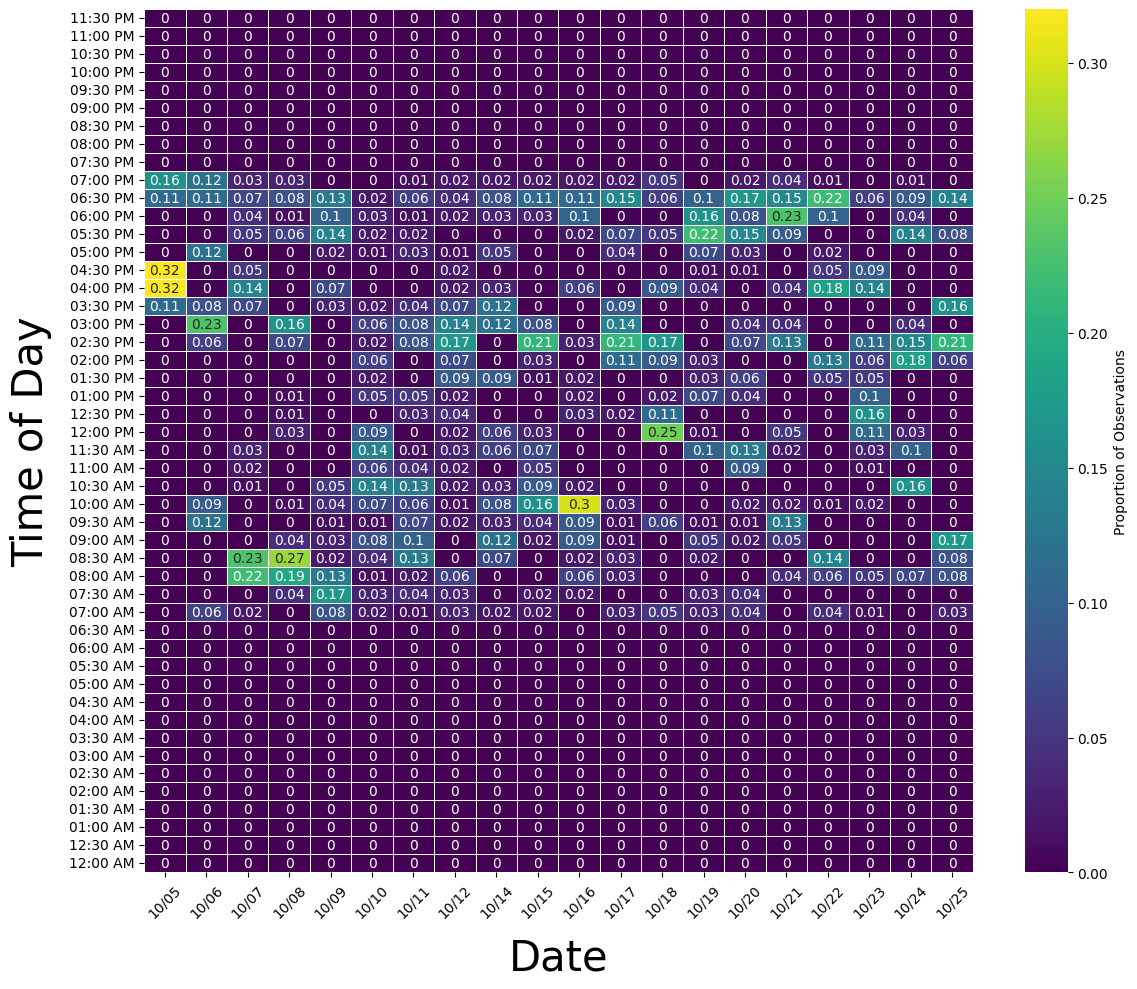

Saved: Heatmap: Date vs Time of Day vs Proportion of Observations -> heatmap_proportions


'heatmap_proportions'

In [8]:
# Heatmap of proportions using helper
fig = plot_heatmap_proportions(complete_data, time_labels)

# Save proportions heatmap for dashboard
save_plot_for_dashboard(
    fig, 
    'heatmap_proportions', 
    'Heatmap: Date vs Time of Day vs Proportion of Observations',
    'Heatmap showing proportional bird activity patterns across dates and times of day'
)

# Bout Analyses

/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_98938/3641986999.py:7: RuntimeWarning: overflow encountered in exp
  return np.log(A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t) + 1e-10)


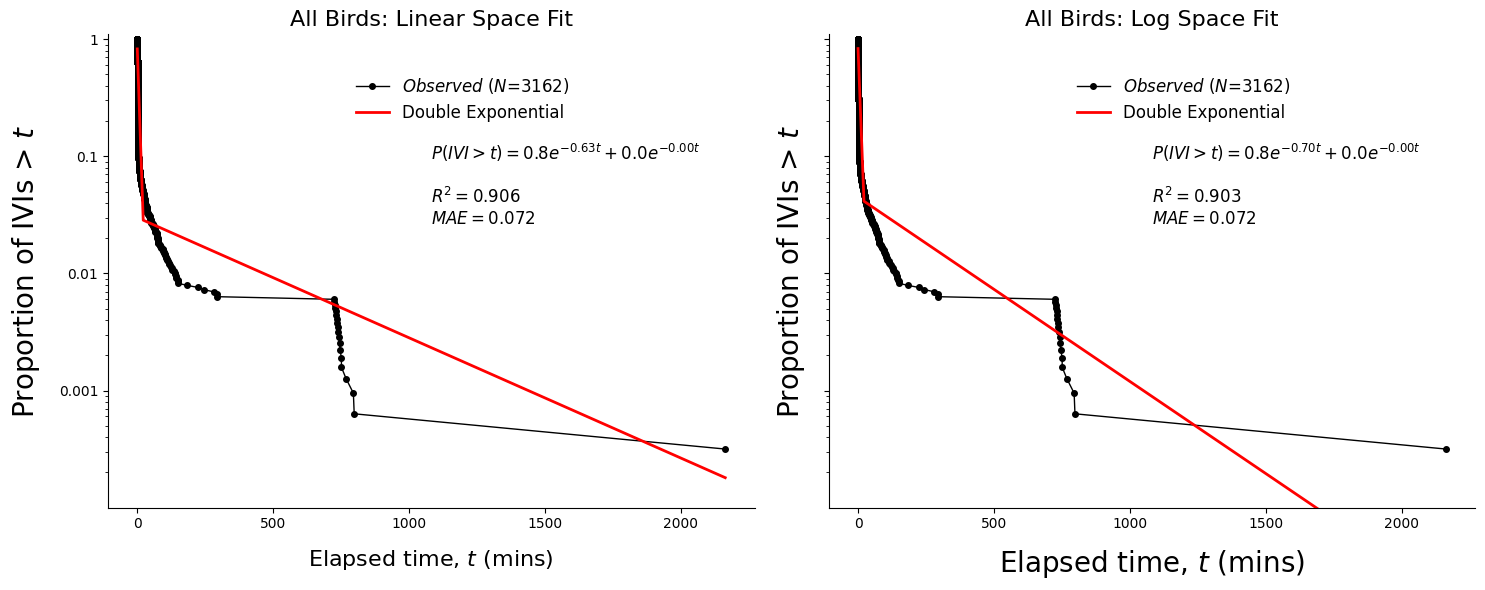

In [9]:
def double_exponential_survivor(t, A1, lambda1, A2, lambda2):
    """Double exponential survivor function"""
    return A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t)

def double_exponential_log_survivor(t, A1, lambda1, A2, lambda2):
    """Double exponential in log-space"""
    return np.log(A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t) + 1e-10)

# Get IVI data (remove NaN values)
ivi_data = raw_data['IVI (mins)'].dropna()

# Sort the data
sorted_ivi = np.sort(ivi_data)

# Calculate survivor function
n = len(sorted_ivi)
survivor = np.arange(n, 0, -1) / n

# Create time points for fitting (use the sorted IVI values)
time_points = sorted_ivi

# Initial parameter guesses
initial_guess = [0.4, 0.5, 0.6, 0.02]

# Fit the double exponential model to survivor function (linear space)
popt_linear, pcov_linear = curve_fit(double_exponential_survivor, time_points, survivor, 
                     p0=initial_guess, maxfev=10000)

# Fit the double exponential model in log space
log_survivor = np.log(survivor + 1e-10)
popt_log, pcov_log = curve_fit(double_exponential_log_survivor, time_points, log_survivor, 
                     p0=initial_guess, maxfev=10000)

# Calculate R-squared and MAE for linear fit
y_pred_linear = double_exponential_survivor(time_points, *popt_linear)
r_squared_linear = 1 - (np.sum((survivor - y_pred_linear) ** 2) / np.sum((survivor - np.mean(survivor)) ** 2))
mae_linear = np.mean(np.abs(survivor - y_pred_linear))

# Calculate R-squared and MAE for log fit
y_pred_log = double_exponential_log_survivor(time_points, *popt_log)
y_pred_log_linear = np.exp(y_pred_log)
r_squared_log = 1 - (np.sum((survivor - y_pred_log_linear) ** 2) / np.sum((survivor - np.mean(survivor)) ** 2))
mae_log = np.mean(np.abs(survivor - y_pred_log_linear))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot 1: Linear space fit
ax1.semilogy(time_points, survivor, 'ko-', markersize=4, linewidth=1, 
             label=f'$Observed$ ($N$={len(ivi_data)})')

# Plot fitted model
t_smooth = np.linspace(0, ivi_data.max(), 100)
y_smooth = double_exponential_survivor(t_smooth, *popt_linear)
ax1.semilogy(t_smooth, y_smooth, 'r-', linewidth=2, 
             label=f'Double Exponential')

# Plot individual components
within_bout = popt_linear[0] * np.exp(-popt_linear[1] * t_smooth)
between_bout = popt_linear[2] * np.exp(-popt_linear[3] * t_smooth)

text_x = 0.5

ax1.set_xlabel('Elapsed time, $t$ (mins)', fontsize=16, labelpad=12)
ax1.set_ylabel(f'Proportion of IVIs > $t$', fontsize=20, labelpad=12)
ax1.legend(loc=(text_x-0.127, 0.8), fontsize=12, frameon=False)
ax1.set_yticks(ticks=[0.001, 0.01, 0.1, 1], 
               labels=['0.001', '0.01', '0.1', '1'], 
               fontsize=10)
ax1.tick_params(axis='x', labelsize=10)
ax1.set_ylim(0.0001, 1.1)

# Add equation text with LaTeX formatting
equation_text = f'$P(IVI>t) = {popt_linear[0]:.1f}e^{{-{popt_linear[1]:.2f}t}} + {popt_linear[2]:.1f}e^{{-{popt_linear[3]:.2f}t}}$'
ax1.text(text_x, 0.735, equation_text, transform=ax1.transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='white'),
         fontsize=12)

# Add metrics text
metrics_text = f'$R^2 = {r_squared_linear:.3f}$\n$MAE = {mae_linear:.3f}$'
ax1.text(text_x, 0.6, metrics_text, transform=ax1.transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='white'),
         fontsize=12)

ax1.set_title("All Birds: Linear Space Fit", fontsize=16)
sns.despine(top=True, right=True, ax=ax1)

# Plot 2: Log space fit
ax2.semilogy(time_points, survivor, 'ko-', markersize=4, linewidth=1, 
             label=f'$Observed$ ($N$={len(ivi_data)})')

# Plot fitted model (transform back to linear space)
y_smooth_log = double_exponential_log_survivor(t_smooth, *popt_log)
y_smooth_log_linear = np.exp(y_smooth_log)
ax2.semilogy(t_smooth, y_smooth_log_linear, 'r-', linewidth=2, 
             label=f'Double Exponential')

# Plot individual components (transform back to linear space)
within_bout_log = np.log(popt_log[0] * np.exp(-popt_log[1] * t_smooth) + 1e-10)
between_bout_log = np.log(popt_log[2] * np.exp(-popt_log[3] * t_smooth) + 1e-10)
within_bout_log_linear = np.exp(within_bout_log)
between_bout_log_linear = np.exp(between_bout_log)

ax2.set_xlabel('Elapsed time, $t$ (mins)', fontsize=20, labelpad=12)
ax2.set_ylabel(f'Proportion of IVIs > $t$', fontsize=20, labelpad=12)
ax2.legend(loc=(text_x-0.127, 0.8), fontsize=12, frameon=False)
ax2.set_yticks(ticks=[0.001, 0.01, 0.1, 1], 
               labels=['0.001', '0.01', '0.1', '1'], 
               fontsize=10)
ax2.tick_params(axis='x', labelsize=10)
ax2.set_ylim(0.0001, 1.1)

# Add equation text with LaTeX formatting
equation_text = f'$P(IVI>t) = {popt_log[0]:.1f}e^{{-{popt_log[1]:.2f}t}} + {popt_log[2]:.1f}e^{{-{popt_log[3]:.2f}t}}$'
ax2.text(text_x, 0.735, equation_text, transform=ax2.transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='white'),
         fontsize=12)

# Add metrics text
metrics_text = f'$R^2 = {r_squared_log:.3f}$\n$MAE = {mae_log:.3f}$'
ax2.text(text_x, 0.6, metrics_text, transform=ax2.transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='white'),
         fontsize=12)

ax2.set_title("All Birds: Log Space Fit", fontsize=16)
sns.despine(top=True, right=True, ax=ax2)

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.show()

In [10]:
# Save migration correlation plot for dashboard
save_plot_for_dashboard(
    fig, 
    'all_birds_bout_analysis', 
    'All Birds: Bout Analysis',
    'Analysis of bout durations for all birds'
)

Saved: All Birds: Bout Analysis -> all_birds_bout_analysis


'all_birds_bout_analysis'

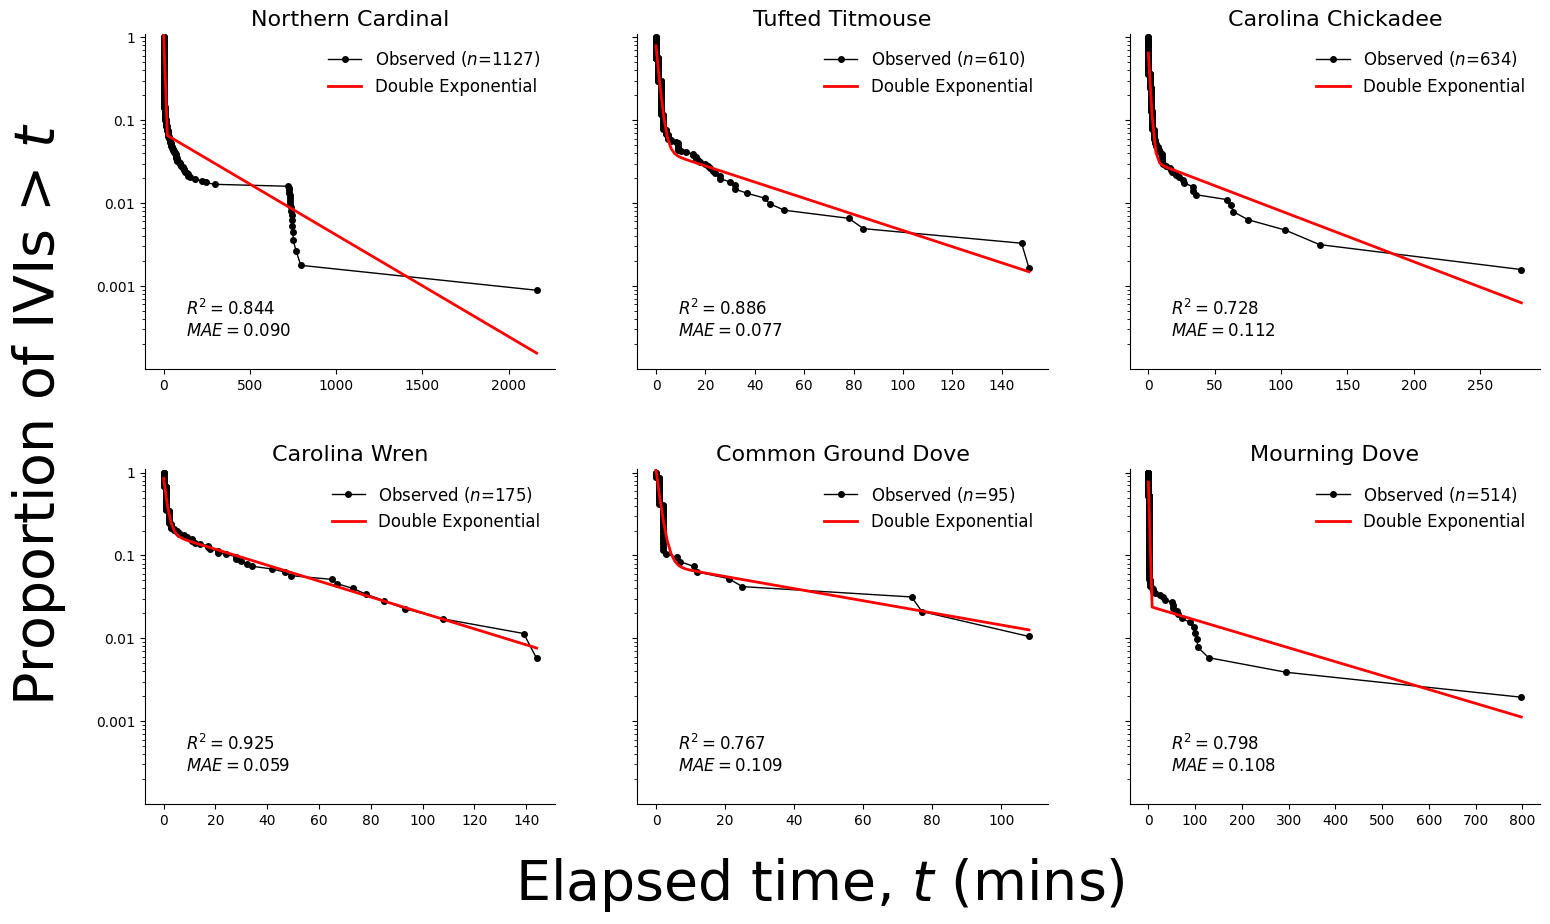

In [11]:
def double_exponential_log_survivor(t, A1, lambda1, A2, lambda2):
    """Double exponential in log-space"""
    return np.log(A1 * np.exp(-lambda1 * t) + A2 * np.exp(-lambda2 * t) + 1e-10)

def fit_bout_model_for_bird(data, bird_species):
    bird_data = data[data['Bird'] == bird_species]['IVI (mins)'].dropna()
    
    if len(bird_data) < 10:
        return None, None, None, None
    
    sorted_ivi = np.sort(bird_data)
    n = len(sorted_ivi)
    survivor = np.arange(n, 0, -1) / n
    time_points = sorted_ivi
    
    # Work in log-space
    log_survivor = np.log(survivor + 1e-10)
    
    # Smart initial guess based on data characteristics
    mean_ivi = bird_data.mean()
    std_ivi = bird_data.std()
    
    # Estimate break point
    break_point = mean_ivi * 0.3
    
    initial_guess = [
        0.8,  # A1 - high initial amplitude
        3.0 / break_point,  # lambda1 - fast decay to break point
        0.2,  # A2 - smaller amplitude for slow component
        0.05 / break_point   # lambda2 - much slower decay
    ]
    
    # Set bounds to prevent unrealistic values
    bounds = ([0, 0.01, 0, 0.001], [1, 20, 1, 1])
    
    try:
        # Fit in log-space
        popt, pcov = curve_fit(double_exponential_log_survivor, time_points, log_survivor, 
                             p0=initial_guess, bounds=bounds, maxfev=15000)
        
        # Convert back to linear space for evaluation
        y_pred_log = double_exponential_log_survivor(time_points, *popt)
        y_pred = np.exp(y_pred_log)
        
        # Calculate metrics in linear space
        r_squared = 1 - (np.sum((survivor - y_pred) ** 2) / np.sum((survivor - np.mean(survivor)) ** 2))
        mae = np.mean(np.abs(survivor - y_pred))
        
        return popt, pcov, r_squared, mae
    except:
        return None, None, None, None

# Get unique bird species
unique_birds = raw_data['Bird'].unique()
unique_birds = unique_birds[unique_birds != 'Gray Catbird']
unique_birds = unique_birds[unique_birds != 'Red-bellied Woodpecker']

# Calculate number of subplots needed
n_species = len(unique_birds)
n_cols = 3
n_rows = (n_species + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), sharey=True)
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

# Plot for each bird species
for i, bird in enumerate(unique_birds):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    
    # Get data for this bird
    bird_data = raw_data[raw_data['Bird'] == bird]['IVI (mins)'].dropna()
    
    if len(bird_data) < 5:
        ax.text(0.5, 0.5, f'Insufficient data\n({len(bird_data)} points)', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(bird, fontsize=16)
        sns.despine(top=True, right=True)
        continue
    
    # Sort the data
    sorted_ivi = np.sort(bird_data)
    
    # Calculate survivor function
    n = len(sorted_ivi)
    survivor = np.arange(n, 0, -1) / n
    
    # Create time points for fitting
    time_points = sorted_ivi
    
    # Fit the model
    popt, pcov, r_squared, mae = fit_bout_model_for_bird(raw_data, bird)
    
    if popt is not None:
        # Plot observed data
        ax.semilogy(time_points, survivor, 'ko-', markersize=4, linewidth=1, 
                   label=f'Observed ($n$={len(bird_data)})')
        
        # Plot fitted model - transform back to linear space
        t_smooth = np.linspace(0, bird_data.max(), 100)
        y_smooth_log = double_exponential_log_survivor(t_smooth, *popt)
        y_smooth = np.exp(y_smooth_log)
        ax.semilogy(t_smooth, y_smooth, 'r-', linewidth=2, 
                   label=f'Double Exponential')
        
        # Plot individual components - transform back to linear space
        within_bout_log = np.log(popt[0] * np.exp(-popt[1] * t_smooth) + 1e-10)
        between_bout_log = np.log(popt[2] * np.exp(-popt[3] * t_smooth) + 1e-10)
        within_bout = np.exp(within_bout_log)
        between_bout = np.exp(between_bout_log)
        
        text_x = 0.1
        
        # Add metrics text
        metrics_text = f'$R^2 = {r_squared:.3f}$\n$MAE = {mae:.3f}$'
        ax.text(text_x, 0.1, metrics_text, transform=ax.transAxes, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='white'),
               fontsize=12)
    else:
        # Plot just the observed data if model fitting failed
        ax.semilogy(time_points, survivor, 'ko-', markersize=4, linewidth=1, 
                   label=f'Observed ($n$={len(bird_data)})')
    
    # Remove individual labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Set formatting
    ax.legend(loc='best', fontsize=12, frameon=False)
    ax.set_yticks(ticks=[0.001, 0.01, 0.1, 1], 
                  labels=['0.001', '0.01', '0.1', '1'], 
                  fontsize=10)
    ax.tick_params(axis='x', labelsize=10)
    ax.set_ylim(0.0001, 1.1)
    ax.set_title(bird, fontsize=16)
    
    sns.despine(top=True, right=True)

# Hide empty subplots
for i in range(n_species, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].set_visible(False)

# Add single super labels
fig.supxlabel('Elapsed time, $t$ (mins)', fontsize=40, y=0.0)
fig.supylabel('Proportion of IVIs > $t$', fontsize=40, x=0.05)

plt.subplots_adjust(hspace=0.3)
plt.show()

In [12]:
# Save migration correlation plot for dashboard
save_plot_for_dashboard(
    fig, 
    'individual_species_bout_analysis', 
    'Individual Birds: Bout Analysis (log space)',
    'Analysis of bout durations for individual bird species'
)


Saved: Individual Birds: Bout Analysis (log space) -> individual_species_bout_analysis


'individual_species_bout_analysis'

# Add Migration Information

In [13]:
bird_cast = pd.read_parquet(BIRDCAST_PARQUET)
bird_cast = bird_cast[bird_cast['region_name'] == 'Duval County, Florida'].reset_index(drop=True)
bird_cast['migration_start_utc'] = pd.to_datetime(bird_cast['migration_start_utc'])
# Trim and copy to avoid SettingWithCopyWarning
bird_cast_trim = bird_cast[bird_cast['migration_start_utc'] > '2025-10-02'].copy()
# Scale to millions using .loc assignment
bird_cast_trim.loc[:, 'total_birds'] = bird_cast_trim['total_birds'] / 1_000_000

/var/folders/c5/vpx80swj4yb9ytlnrk8w2qnr0000gn/T/ipykernel_98938/1294575394.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<FloatingArray>
[ 2.3571,  0.9762,  6.3763,  0.3449,   3.768,  0.6249,  0.0057,  2.6771,
   6.035,  5.1438,  3.6487, 14.2004,  4.7892,  0.7991,  0.7572,   0.413]
Length: 16, dtype: Float64' has dtype incompatible with Int64, please explicitly cast to a compatible dtype first.
  bird_cast_trim.loc[:, 'total_birds'] = bird_cast_trim['total_birds'] / 1_000_000


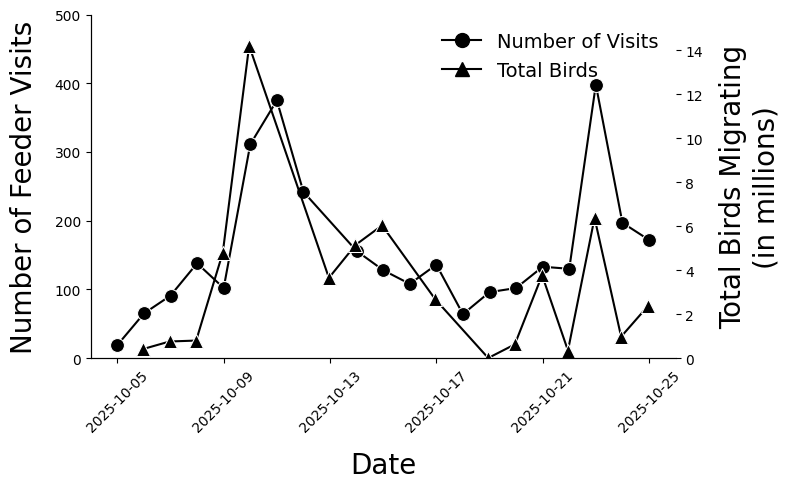

In [14]:
all_birds_feeder = daily_summs.groupby('Date')['Feeder Visits'].sum()
all_birds_feeder = pd.DataFrame(all_birds_feeder).reset_index()

fig, ax1 = plt.subplots(figsize=(8, 5))

# First lineplot on primary y-axis
sns.lineplot(
    x='Date', 
    y='Feeder Visits', 
    data=all_birds_feeder, 
    ax=ax1, 
    marker='o', 
    markersize=10,
    color='black',
    label='Number of Visits',
    legend=False
)

# Create secondary y-axis
ax2 = ax1.twinx()

# Second lineplot on secondary y-axis
sns.lineplot(
    x='migration_start_utc',
    y='total_birds',
    data=bird_cast_trim,
    ax=ax2,
    marker='^',
    markersize=10, 
    color='black', 
    label='Total Birds',
    legend=False
)

# Set custom scale for secondary y-axis
ax2.set_ylim(0, bird_cast_trim['total_birds'].max() * 1.1)
ax1.set_ylim(0, 500)

# Set labels for both axes
ax1.set_ylabel('Number of Feeder Visits', fontsize=20, labelpad=12)
ax1.set_xlabel('Date', fontsize=20, labelpad=12)
ax2.set_ylabel('Total Birds Migrating\n(in millions)', fontsize=20, labelpad=12)

# Style the plot
sns.despine(top=True)

# Create a combined legend manually
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', marker='o', linestyle='-', markersize=10, label='Number of Visits'),
    Line2D([0], [0], color='black', marker='^', linestyle='-', markersize=10, label='Total Birds')
]
plt.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=14)

# Rotate x-axis labels
ax1.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [15]:
# Save migration correlation plot for dashboard
save_plot_for_dashboard(
    fig, 
    'migration_relation', 
    'Feeder Visits Compared to Migration Activity',
    'Relationship between feeder visits and migration activity from BirdCast data'
)

Saved: Feeder Visits Compared to Migration Activity -> migration_relation


'migration_relation'

## Calculating Daily and Weekly Diversity

In [16]:
def calculate_species_richness(daily_summs_df):
    """
    Calculate species richness (number of unique species) per day.
    
    Parameters:
    daily_summs_df: DataFrame with columns ['Date', 'Bird', 'Feeder Visits', ...]
    
    Returns:
    DataFrame with Date and richness columns
    """
    daily = daily_summs_df.copy()
    daily['Date'] = pd.to_datetime(daily['Date'])
    
    richness = daily.groupby("Date")["Bird"].nunique().reset_index()
    richness.columns = ['Date', 'richness']
    
    return richness

def calculate_shannon_h(daily_summs_df):
    """
    Calculate Shannon H (alpha diversity) per day.
    
    Parameters:
    daily_summs_df: DataFrame with columns ['Date', 'Bird', 'Feeder Visits', ...]
    
    Returns:
    DataFrame with Date and shannon_H columns
    """
    daily = daily_summs_df.copy()
    daily['Date'] = pd.to_datetime(daily['Date'])
    
    # Create pivot table: dates as rows, bird species as columns, feeder visits as values
    day_species = daily.pivot_table(
        index="Date", 
        columns="Bird", 
        values="Feeder Visits", 
        aggfunc="sum", 
        fill_value=0
    )
    
    # Calculate proportions (relative abundance) for each species on each day
    # Replace 0 with NaN to avoid log(0) issues
    p = day_species.div(day_species.sum(axis=1), axis=0).replace(0, np.nan)
    
    # Calculate Shannon H: -sum(p * log(p))
    shannon = (-(p * np.log(p)).sum(axis=1)).reset_index()
    shannon.columns = ['Date', 'shannon_H']
    
    return shannon

def calculate_weekly_sorensen_dissimilarity(daily_summs_df):
    """
    Calculate Sørensen dissimilarity between consecutive weeks.
    
    Parameters:
    daily_summs_df: DataFrame with columns ['Date', 'Bird', 'Feeder Visits', ...]
    
    Returns:
    DataFrame with Date and sorensen_dissimilarity columns
    """
    daily = daily_summs_df.copy()
    daily['Date'] = pd.to_datetime(daily['Date'])
    daily['week'] = daily['Date'].dt.isocalendar().week
    
    # Create weekly presence/absence matrix (1 if species visited that week, 0 otherwise)
    weekly_presence = (daily.groupby(["week", "Bird"])["Feeder Visits"]
                       .sum().unstack(fill_value=0) > 0).astype(int)
    
    # Calculate Sørensen dissimilarity between consecutive weeks
    sorensen = []
    weeks_sorted = sorted(weekly_presence.index)
    
    for w_prev, w_curr in zip(weeks_sorted[:-1], weeks_sorted[1:]):
        a = weekly_presence.loc[w_prev]  # Previous week species presence
        b = weekly_presence.loc[w_curr]  # Current week species presence
        
        a_sum = a.sum()  # Number of species in previous week
        b_sum = b.sum()  # Number of species in current week
        intersection = (a & b).sum()  # Number of species in both weeks
        
        # Sørensen dissimilarity formula: 1 - (2 * intersection) / (a_sum + b_sum)
        denom = (a_sum + b_sum)
        d_s = np.nan if denom == 0 else 1 - (2 * intersection / denom)
        
        sorensen.append({
            "week": w_curr, 
            "sorensen_dissimilarity": d_s
        })
    
    # Convert to DataFrame
    beta_df = pd.DataFrame(sorensen)
    
    # Get all dates and their weeks
    all_dates = daily[['Date', 'week']].drop_duplicates().sort_values('Date')
    
    # Merge with Sørensen dissimilarity data
    result_df = all_dates.merge(beta_df, on='week', how='left')
    result_df = result_df[['Date', 'sorensen_dissimilarity']]
    
    return result_df

def calculate_rolling_sorensen_dissimilarity(daily_summs_df):
    """
    Calculate Sørensen dissimilarity using rolling 3-day comparisons.
    Compares (7,8,9) days ago to (0,1,2) days ago for each day.
    
    Parameters:
    daily_summs_df: DataFrame with columns ['Date', 'Bird', 'Feeder Visits', ...]
    
    Returns:
    DataFrame with Date and rolling_sorensen_dissimilarity columns
    """
    daily = daily_summs_df.copy()
    daily['Date'] = pd.to_datetime(daily['Date'])
    daily = daily.sort_values('Date').reset_index(drop=True)
    
    # Create daily presence/absence matrix (1 if species visited that day, 0 otherwise)
    daily_presence = (daily.groupby(["Date", "Bird"])["Feeder Visits"]
                      .sum().unstack(fill_value=0) > 0).astype(int)
    
    # Get sorted dates
    dates_sorted = sorted(daily_presence.index)
    
    # Calculate rolling 3-day Sørensen dissimilarity
    sorensen_values = []
    
    for i in range(len(dates_sorted)):
        current_date = dates_sorted[i]
        
        # Define the two 3-day periods to compare
        # Period A: 7-9 days ago (days i-9, i-8, i-7)
        # Period B: 0-2 days ago (days i-2, i-1, i)
        
        period_a_dates = []
        period_b_dates = []
        
        # Get dates for period A (7-9 days ago)
        for offset in [9, 8, 7]:
            if i - offset >= 0:
                period_a_dates.append(dates_sorted[i - offset])
        
        # Get dates for period B (0-2 days ago)
        for offset in [2, 1, 0]:
            if i - offset >= 0:
                period_b_dates.append(dates_sorted[i - offset])
        
        # Only calculate if we have at least one date in each period
        if len(period_a_dates) > 0 and len(period_b_dates) > 0:
            # Get species presence for each period
            period_a_presence = daily_presence.loc[period_a_dates].any(axis=0)  # Any species present in period A
            period_b_presence = daily_presence.loc[period_b_dates].any(axis=0)  # Any species present in period B
            
            # Calculate Sørensen dissimilarity
            a_sum = period_a_presence.sum()  # Number of species in period A
            b_sum = period_b_presence.sum()  # Number of species in period B
            intersection = (period_a_presence & period_b_presence).sum()  # Number of species in both periods
            
            # Sørensen dissimilarity formula: 1 - (2 * intersection) / (a_sum + b_sum)
            denom = (a_sum + b_sum)
            d_s = np.nan if denom == 0 else 1 - (2 * intersection / denom)
            
            sorensen_values.append(d_s)
        else:
            sorensen_values.append(np.nan)
    
    # Create result DataFrame
    result_df = pd.DataFrame({
        'Date': dates_sorted,
        'rolling_sorensen_dissimilarity': sorensen_values
    })
    
    return result_df

# Calculate each metric separately
richness_df = calculate_species_richness(daily_summs)
shannon_df = calculate_shannon_h(daily_summs)
weekly_sorensen_df = calculate_weekly_sorensen_dissimilarity(daily_summs)
rolling_sorensen_df = calculate_rolling_sorensen_dissimilarity(daily_summs)

# Merge all metrics into a single dataframe
diversity_metrics_clean = richness_df.merge(shannon_df, on='Date', how='outer')
diversity_metrics_clean = diversity_metrics_clean.merge(weekly_sorensen_df, on='Date', how='outer')
diversity_metrics_clean = diversity_metrics_clean.merge(rolling_sorensen_df, on='Date', how='outer')

# Sort by date
diversity_metrics_clean = diversity_metrics_clean.sort_values('Date').reset_index(drop=True)

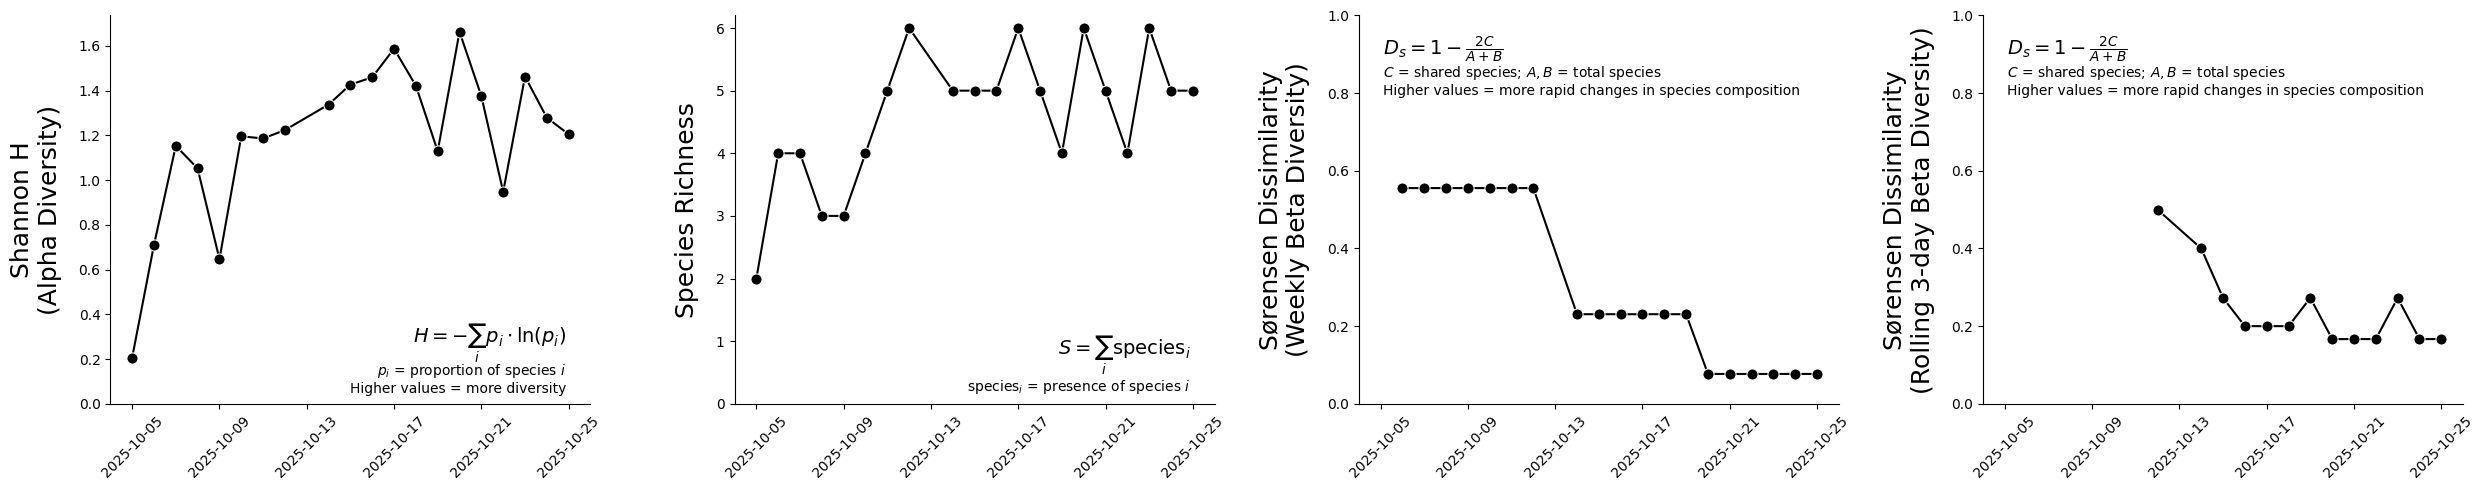


INTERPRETATION OF ALL DIVERSITY METRICS:
• Shannon H (Alpha Diversity) - Left:
  - Measures species diversity within each day
  - Higher values = more diverse bird community
  - Considers both species richness and evenness

• Species Richness - Second from Left:
  - Simple count of unique bird species per day
  - Higher values = more species present

• Weekly Sørensen Dissimilarity (Beta Diversity) - Third from Left:
  - Measures how different bird communities are between weeks
  - 0 = identical species composition
  - 1 = completely different species composition

• Rolling 3-day Sørensen Dissimilarity (Beta Diversity) - Right:
  - Compares species composition between two 3-day periods:
    * Period A: 7-9 days ago
    * Period B: 0-2 days ago
  - Provides more frequent, smoother measure of species turnover
  - Higher values = more rapid changes in species composition


In [17]:
# Create 1x4 subplot layout with all four metrics
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 5), sharex=True)

# Plot 1: Shannon H (Alpha Diversity)
sns.lineplot(
    x='Date', 
    y='shannon_H', 
    data=diversity_metrics_clean, 
    ax=ax1, 
    marker='o', 
    markersize=8,
    color='black'
)
ax1.set_ylabel('Shannon H\n(Alpha Diversity)', fontsize=18, labelpad=12)
ax1.set_xlabel('')
ax1.set_ylim(0, )
sns.despine(top=True, right=True, ax=ax1)
# Add Shannon H equation (lower right)
ax1.text(0.95, 0.10, r'$H = -\sum_{i} p_i \cdot \ln(p_i)$', transform=ax1.transAxes, 
         fontsize=14, ha='right', va='bottom')
ax1.text(0.95, 0.02, f'$p_i$ = proportion of species $i$\nHigher values = more diversity', transform=ax1.transAxes, 
         fontsize=10, ha='right', va='bottom')

# Plot 2: Species Richness
sns.lineplot(
    x='Date', 
    y='richness', 
    data=diversity_metrics_clean, 
    ax=ax2, 
    marker='o', 
    markersize=8,
    color='black'
)
ax2.set_ylabel('Species Richness', fontsize=18, labelpad=12)
ax2.set_xlabel('')
ax2.set_ylim(0, )
sns.despine(top=True, right=True, ax=ax2)
# Add Species Richness equation (lower right)
ax2.text(0.95, 0.07, r'$S = \sum_{i} \text{species}_i$', transform=ax2.transAxes, 
         fontsize=14, ha='right', va='bottom')
ax2.text(0.95, 0.02, r'$\text{species}_i$ = presence of species $i$', transform=ax2.transAxes, 
         fontsize=10, ha='right', va='bottom')

# Plot 3: Weekly Sørensen Dissimilarity (original)
sorensen_weekly_data = diversity_metrics_clean.dropna(subset=['sorensen_dissimilarity'])
if not sorensen_weekly_data.empty:
    sns.lineplot(
        x='Date', 
        y='sorensen_dissimilarity', 
        data=sorensen_weekly_data, 
        ax=ax3, 
        marker='o', 
        markersize=8,
        color='black'
    )
    ax3.set_ylabel('Sørensen Dissimilarity\n(Weekly Beta Diversity)', fontsize=18, labelpad=12)
    ax3.set_xlabel('')
    ax3.set_ylim(0, 1)
    # Add Sørensen equation (upper left)
    ax3.text(0.05, 0.95, r'$D_s = 1 - \frac{2C}{A + B}$', transform=ax3.transAxes, 
             fontsize=14, ha='left', va='top')
    ax3.text(0.05, 0.875, f'$C$ = shared species; $A,B$ = total species\nHigher values = more rapid changes in species composition', transform=ax3.transAxes, 
             fontsize=10, ha='left', va='top')
else:
    ax3.text(0.5, 0.5, 'No weekly Sørensen data available\n(need at least 2 weeks)', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)

sns.despine(top=True, right=True, ax=ax3)

# Plot 4: Rolling 3-day Sørensen Dissimilarity (new)
sorensen_rolling_data = diversity_metrics_clean.dropna(subset=['rolling_sorensen_dissimilarity'])
if not sorensen_rolling_data.empty:
    sns.lineplot(
        x='Date', 
        y='rolling_sorensen_dissimilarity', 
        data=sorensen_rolling_data, 
        ax=ax4, 
        marker='o', 
        markersize=8,
        color='black'
    )
    ax4.set_ylabel('Sørensen Dissimilarity\n(Rolling 3-day Beta Diversity)', fontsize=18, labelpad=12)
    ax4.set_xlabel('')
    ax4.set_ylim(0, 1)
    # Add Sørensen equation (upper left)
    ax4.text(0.05, 0.95, r'$D_s = 1 - \frac{2C}{A + B}$', transform=ax4.transAxes, 
             fontsize=14, ha='left', va='top')
    ax4.text(0.05, 0.875, f'$C$ = shared species; $A,B$ = total species\nHigher values = more rapid changes in species composition', transform=ax4.transAxes, 
             fontsize=10, ha='left', va='top')
else:
    ax4.text(0.5, 0.5, 'No rolling Sørensen data available\n(need at least 10 days)', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)

sns.despine(top=True, right=True, ax=ax4)

# Rotate x-axis labels for all subplots
for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

# Print interpretation
print("\n" + "="*80)
print("INTERPRETATION OF ALL DIVERSITY METRICS:")
print("="*80)
print("• Shannon H (Alpha Diversity) - Left:")
print("  - Measures species diversity within each day")
print("  - Higher values = more diverse bird community")
print("  - Considers both species richness and evenness")

print("\n• Species Richness - Second from Left:")
print("  - Simple count of unique bird species per day")
print("  - Higher values = more species present")

print("\n• Weekly Sørensen Dissimilarity (Beta Diversity) - Third from Left:")
print("  - Measures how different bird communities are between weeks")
print("  - 0 = identical species composition")
print("  - 1 = completely different species composition")

print("\n• Rolling 3-day Sørensen Dissimilarity (Beta Diversity) - Right:")
print("  - Compares species composition between two 3-day periods:")
print("    * Period A: 7-9 days ago")
print("    * Period B: 0-2 days ago")
print("  - Provides more frequent, smoother measure of species turnover")
print("  - Higher values = more rapid changes in species composition")

In [18]:
# Save diversity metrics plot for dashboard
save_plot_for_dashboard(
    fig, 
    'diversity_metrics', 
    'Ecological Diversity Metrics',
    'Shannon H diversity and species richness metrics over time'
)

Saved: Ecological Diversity Metrics -> diversity_metrics


'diversity_metrics'